In [1]:
pip install group-lasso

Note: you may need to restart the kernel to use updated packages.


In [157]:
from group_lasso import LogisticGroupLasso

In [158]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import sklearn as sk
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn import impute

strokedata = pd.read_csv('healthcare-dataset-stroke-data.csv')
strokedata.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# EDA and Imputation

In [159]:
strokedata.shape[0]

5110

In [160]:
strokedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Since the BMI non-null count is 4909, which is less than the number of observations, this column has null values, and the other columns do not have null values.

In [161]:
strokedata.loc[strokedata['bmi'].isnull()].stroke.value_counts()

0    161
1     40
Name: stroke, dtype: int64

In [162]:
# Create a copy of the bmi column for imputation
strokedata['imputed_bmi'] = strokedata['bmi']
# Create a column that will say if bmi has been imputed or not
strokedata['bmi_original'] = 'no'

In [163]:
strokedata.loc[strokedata['bmi'].isnull(), 'bmi_original'] = 'yes'

In [164]:
strokedata.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,imputed_bmi,bmi_original
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,36.6,no
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,NaN,yes
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,32.5,no
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,34.4,no
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,24.0,no


In [165]:
strokedata['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

If we remove our BMI data, we lose about 1/6 of our overall data, so we will proceed to impute the data through KNN. First, we need to create a subset of the numeric columns and scale the data.

In [166]:
import sklearn as sk
from sklearn import preprocessing

#Considering numeric columns in the data to use KNN
num_cols = [2, 8, 12] # age and avg_glucose_level and imputed_bmi

#Create an object of type MinMaxScaler
scaler = sk.preprocessing.MinMaxScaler()

#Use the object method 'fit_transform' to scale the values to a standard uniform distribution
scaled_data = pd.DataFrame(scaler.fit_transform(strokedata.iloc[:,num_cols]))

In [167]:
scaled_data.head()

,0,1,2
0,0.816895,0.801265,0.301260
1,0.743652,0.679023,NaN
2,0.975586,0.234512,0.254296
3,0.597168,0.536008,0.276060
4,0.963379,0.549349,0.156930


In [168]:
#Imputing missing values with KNNImputer

#Define an object of type KNNImputer
imputer = impute.KNNImputer(n_neighbors=3, weights="uniform")

#Use the object method 'fit_transform' to impute missing values
imputed_arr = imputer.fit_transform(scaled_data)

#Scaling back the scaled array to obtain the data at the original scale

#Use the object method 'inverse_transform' to scale back the values to the original scale of the data
unscaled_data = scaler.inverse_transform(imputed_arr)

In [169]:
#Note the method imputes the missing value of all the columns
#However, we are interested in imputing the missing values of only the 'imputed_bmi' column

strokedata.loc[:,'imputed_bmi'] = unscaled_data[:,2]

In [176]:
# Check that we imputed the values

strokedata['imputed_bmi'].isnull().sum()

0

We successfully imputed the values of `bmi` using `age` and `avg_glucose_level` using KNN.

# Creating test and training data frame

In [171]:
np.random.seed(2)
train = strokedata.sample(round(strokedata.shape[0]*0.7))
test = strokedata.drop(train.index)

Train data consists of [3577 rows x 12 columns]  and test data consists of [1533 rows x 12 columns]

# Dummy Variables

In [172]:
traind = pd.get_dummies(train)
traind.head()
testd = strokedata.drop(traind.index)
testd = pd.get_dummies(testd)
print(testd.shape)
print(traind.shape)
testd.head()
train['gender'].unique()

(1533, 25)
(3577, 26)


array(['Female', 'Male', 'Other'], dtype=object)

# Helper Function Creation 

In [183]:
#helper functions

#variable transformations
def var_transform(data):
    duration_binned = pd.qcut(train['duration'], 8, retbins = True)
    bins = duration_binned[1]
    data['duration_binned'] = pd.cut(data['duration'], bins = bins)
    return data

#jitter the values
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)

#Function to compute confusion matrix and prediction accuracy on training data
def confusion_matrix_train(model,cutoff=0.5):
    # Confusion matrix
    cm_df = pd.DataFrame(model.pred_table(threshold = cutoff))
    #Formatting the confusion matrix
    cm_df.columns = ['Predicted 0', 'Predicted 1'] 
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))

#Function to compute confusion matrix and prediction accuracy on test data
#Function to compute confusion matrix and prediction accuracy on test data
def confusion_matrix_test(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    f1 = 2*(precision*tpr) / (precision + tpr)
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))
    print("F1 = " + str(f1))
    
#plotting roc
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    

In [178]:
from sklearn.metrics import precision_recall_curve
y = train.stroke # True response values
ypred = logit_model.predict(train) # predicted response values

#to call:
#p, r, thresholds = precision_recall_curve(y, ypred)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
# to call:
# plot_precision_recall_vs_threshold(p, r, thresholds)

# VIF Test

In [175]:
traind.columns

Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'stroke', 'imputed_bmi', 'gender_Female', 'gender_Male',
       'gender_Other', 'ever_married_No', 'ever_married_Yes',
       'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'bmi_original_no', 'bmi_original_yes'],
      dtype='object')

In [20]:
predictors = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level',
           'imputed_bmi', 'gender_Female', 'gender_Male',
       'gender_Other', 'ever_married_No', 'ever_married_Yes',
       'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes']
X = traind[predictors] 

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

                           feature       VIF
0                            const  0.000000
1                              age  2.834028
2                     hypertension  1.117608
3                    heart_disease  1.114110
4                avg_glucose_level  1.105810
5                      imputed_bmi  1.326531
6                    gender_Female       inf
7                      gender_Male       inf
8                     gender_Other       inf
9                  ever_married_No       inf
10                ever_married_Yes       inf
11              work_type_Govt_job       inf
12          work_type_Never_worked       inf
13               work_type_Private       inf
14         work_type_Self-employed       inf
15              work_type_children       inf
16            Residence_type_Rural       inf
17            Residence_type_Urban       inf
18          smoking_status_Unknown       inf
19  smoking_status_formerly smoked       inf
20     smoking_status_never smoked       inf
21        

/Users/caraannechang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/caraannechang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/caraannechang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


All of the collinear variables are due to associations between dummy categories.

# Examining the Distribution of the Target Column

In [21]:
train.stroke.value_counts()

0    3407
1     170
Name: stroke, dtype: int64

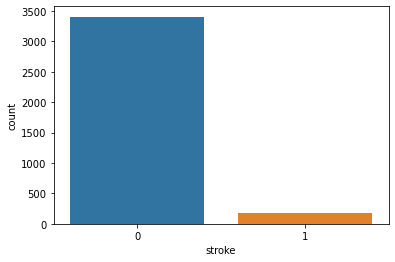

In [22]:
sns.countplot(x = 'stroke',data = train);

# Lasso Selection

In [23]:
y=traind.stroke

In [24]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

#Standardizing predictors so that each of them have zero mean and unit variance

#Defining a scaler object
scalerr = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
scalerr.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scalerr.transform(X)

In [25]:
#Creating a range of values of the tuning parameter to visualize the lasso coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,100)*0.1

In [26]:
#Finding the ridge regression coefficients for increasing values of the tuning parameter
#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)

Text(0, 0.5, 'Standardized coefficient')

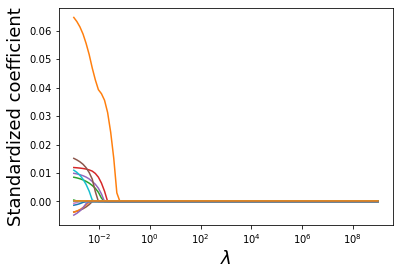

In [27]:
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')

In [28]:
#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

0.0013524798652315671

The 10-fold cross validation error minimizes at lambda = 0.001.

In [29]:
#Checking the coefficients of the lasso model
lasso.coef_

for i in range(21):
    print(predictors[i], lasso.coef_[i])

age 0.0
hypertension 0.0646092410352565
heart_disease 0.008508993748070284
avg_glucose_level 0.011912393576721565
imputed_bmi 0.00988292751959109
gender_Female -0.003701162547613484
gender_Male 0.0
gender_Other -0.0
ever_married_No -0.0
ever_married_Yes 0.010974166165247464
work_type_Govt_job -6.331716439014032e-18
work_type_Never_worked -0.003758956414867484
work_type_Private 0.0005058317560568087
work_type_Self-employed 0.0
work_type_children -0.0047898425585102995
Residence_type_Rural 0.015140352243811547
Residence_type_Urban -0.0006642707692392041
smoking_status_Unknown 0.0
smoking_status_formerly smoked 0.0
smoking_status_never smoked 3.421898296650788e-05
smoking_status_smokes -0.0013247454159403711


[All of the zeroed variables would be removed according to LASSO]
Going forward, we would have to implement a group lasso technique to account for the dummy variables. We cannot feasibly remove specific categories within dummies. However, this is beyond the scope of the class, so we will proceed with all of the variables. (We will not eliminate age due to academic research suggesting that age is a target indicator for stroke).

# Fitting the initial logistic regression model

Optimization terminated successfully.
         Current function value: 0.153034
         Iterations 9


<AxesSubplot:xlabel='age', ylabel='stroke'>

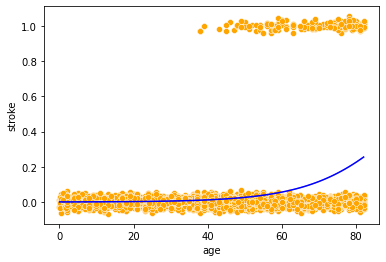

In [30]:
# Include jitter for better visualization of the distribution of 1s and 0s
def jitter(values,j=0):
    return values + np.random.normal(j,0.02,values.shape)

sns.scatterplot(x = jitter(train.age), y = jitter(train.stroke), data = train, color = 'orange')
logit_model = sm.logit(formula = 'stroke~age', data = train).fit()
sns.lineplot(x = 'age', y= logit_model.predict(train), data = train, color = 'blue')

In [31]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 3577
Model:                          Logit   Df Residuals:                     3575
Method:                           MLE   Df Model:                            1
Date:                Sun, 05 Mar 2023   Pseudo R-squ.:                  0.1995
Time:                        13:30:56   Log-Likelihood:                -547.40
converged:                       True   LL-Null:                       -683.80
Covariance Type:            nonrobust   LLR p-value:                 2.803e-61
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.5734      0.429    -17.670      0.000      -8.413      -6.733
age            0.0793      0.006     12.711      0.000       0.067       0.092
==============================================================================
"""

In [32]:
(np.exp(0.0793)-1)*100

8.25290320710006

The coefficient of age is 0.0793, which means for a unit increase in age, the log odds of stroke likeliness increase by 0.0793, or the odds increases by 8.25%.

Assuming a significance level of $\alpha = 0.05$, age seems to be a staistically variable as its p-value and the model's overall LLR p-value are less than our $\alpha$ level.

Print out the correlations for each of the continuous variables to check for possible interactions.

In [33]:
corr_table = train.corr()
corr_table

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,imputed_bmi
id,1.000000,-0.014804,0.001437,0.005596,-0.029385,-0.003362,-0.004766,-0.007601
age,-0.014804,1.000000,0.272511,0.266071,0.226338,0.340309,0.248097,0.338419
hypertension,0.001437,0.272511,1.000000,0.108822,0.169636,0.171667,0.117325,0.166541
heart_disease,0.005596,0.266071,0.108822,1.000000,0.150224,0.049623,0.137965,0.049233
avg_glucose_level,-0.029385,0.226338,0.169636,0.150224,1.000000,0.178433,0.116067,0.182748
bmi,-0.003362,0.340309,0.171667,0.049623,0.178433,1.000000,0.046985,1.000000
stroke,-0.004766,0.248097,0.117325,0.137965,0.116067,0.046985,1.000000,0.044624
imputed_bmi,-0.007601,0.338419,0.166541,0.049233,0.182748,1.000000,0.044624,1.000000


BMI and age have a correlations of 0.340309 that might be worth looking into as an interaction term. To test this, train a basic model using all of the continuous variables and then add in the interaction term.

In [208]:
# basic model with all the continuous vars
logit_model = sm.logit(formula = 'stroke~bmi+avg_glucose_level+age+hypertension', data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.139458
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 3441
Model:                          Logit   Df Residuals:                     3436
Method:                           MLE   Df Model:                            4
Date:                Sun, 05 Mar 2023   Pseudo R-squ.:                  0.2058
Time:                        21:40:15   Log-Likelihood:                -479.88
converged:                       True   LL-Null:                       -604.20
Covariance Type:            nonrobust   LLR p-value:                 1.267e-52
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -8.1837      0.666    -12.294      0.000      -9.488      -6.879
bmi                   0.0074      0.014      0.530      0.596      -0.020       0.035
avg_glucose_level     0.0043      0.002      2.769      0.006       0.001       0.007
age                   0.0742      0.007     10.761      0.000       0.061       0.088
hypertension          0.4752      0.209      2.275      0.023       0.066       0.885
=====================================================================================
"""

BMI does not appear to be statistically significant in this model, to test for the interaction, add an interaction term between BMI and age.

In [181]:
logit_model2 = sm.logit(formula = 'stroke~bmi+I(bmi*age)+avg_glucose_level+age', data = train).fit()
logit_model2.summary()

Optimization terminated successfully.
         Current function value: 0.139646
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 3441
Model:                          Logit   Df Residuals:                     3436
Method:                           MLE   Df Model:                            4
Date:                Sun, 05 Mar 2023   Pseudo R-squ.:                  0.2047
Time:                        21:30:24   Log-Likelihood:                -480.52
converged:                       True   LL-Null:                       -604.20
Covariance Type:            nonrobust   LLR p-value:                 2.402e-52
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -11.0251      1.364     -8.082      0.000     -13.699      -8.351
bmi                   0.0970      0.039      2.501      0.012       0.021       0.173
I(bmi * age)         -0.0014      0.001     -2.238      0.025      -0.003      -0.000
avg_glucose_level     0.0049      0.002      3.237      0.001       0.002       0.008
age                   0.1192      0.021      5.704      0.000       0.078       0.160
=====================================================================================
"""

Classification accuracy = 76.4%
Precision = 12.4%
TPR or Recall = 75.3%
FNR = 24.7%
FPR = 23.5%
ROC-AUC = 85.2%
F1 = 0.21338506304558683


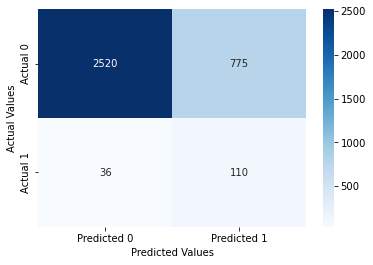

In [209]:
confusion_matrix_data(train.dropna(),train.dropna().stroke,logit_model,cutoff=0.05)

# Confusion matrices for Model #2

Classification accuracy = 95.2%
Precision = 29.5%
TPR or Recall = 8.9%
FNR = 91.1%
FPR = 0.9%
ROC-AUC = 84.9%
F1 = 0.1368421052631579


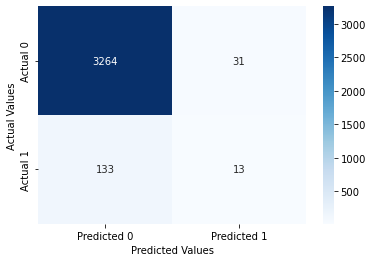

In [185]:
confusion_matrix_data(train.dropna(),train.dropna().stroke,logit_model2,cutoff=0.25)

Classification accuracy = 94.6%
Precision = 18.5%
TPR or Recall = 7.9%
FNR = 92.1%
FPR = 1.6%
ROC-AUC = 83.3%
F1 = 0.1111111111111111


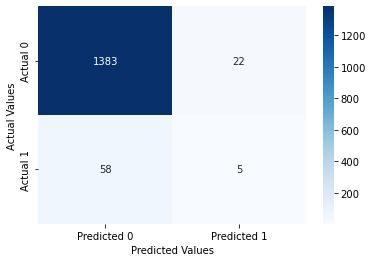

In [186]:
confusion_matrix_data(test.dropna(),test.dropna().stroke,logit_model2,cutoff=0.25)

Classification accuracy = 76.3%
Precision = 12.5%
TPR or Recall = 76.0%
FNR = 24.0%
FPR = 23.6%
ROC-AUC = 84.9%
F1 = 0.21428571428571427


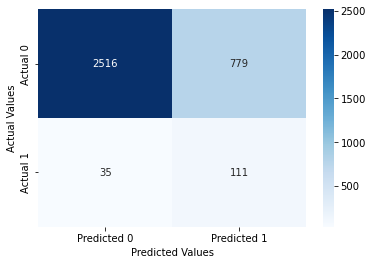

In [187]:
confusion_matrix_data(train.dropna(),train.dropna().stroke,logit_model2,cutoff=0.05)

Classification accuracy = 75.7%
Precision = 12.1%
TPR or Recall = 74.6%
FNR = 25.4%
FPR = 24.2%
ROC-AUC = 83.3%
F1 = 0.2088888888888889


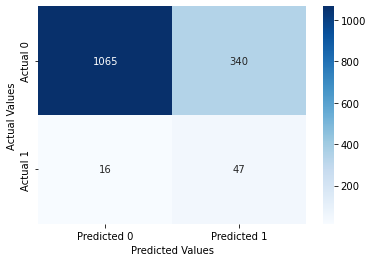

In [188]:
confusion_matrix_data(test.dropna(),test.dropna().stroke,logit_model2,cutoff=0.05)

By making the cutoff so low, we were able to increase our recall value in exchange for our precision. Because there are so few positive cases in our train data, even with a much higher cutoff, the precision was still low. The classification accuracy also fell a bit. 

# Since this model will be used for diagnosis, we must minimize FNR. 

In [189]:
logit_model3 = sm.logit(formula = 'stroke~bmi+I(bmi*age)+avg_glucose_level+age+hypertension', data = train).fit()
logit_model3.summary()

Optimization terminated successfully.
         Current function value: 0.138956
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 3441
Model:                          Logit   Df Residuals:                     3435
Method:                           MLE   Df Model:                            5
Date:                Sun, 05 Mar 2023   Pseudo R-squ.:                  0.2086
Time:                        21:31:55   Log-Likelihood:                -478.15
converged:                       True   LL-Null:                       -604.20
Covariance Type:            nonrobust   LLR p-value:                 1.936e-52
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -10.7424      1.344     -7.995      0.000     -13.376      -8.109
bmi                   0.0904      0.038      2.374      0.018       0.016       0.165
I(bmi * age)         -0.0014      0.001     -2.177      0.029      -0.003      -0.000
avg_glucose_level     0.0045      0.002      2.947      0.003       0.002       0.008
age                   0.1153      0.021      5.597      0.000       0.075       0.156
hypertension          0.4667      0.209      2.233      0.026       0.057       0.876
=====================================================================================
"""

Classification accuracy = 94.1%
Precision = 18.9%
TPR or Recall = 11.1%
FNR = 88.9%
FPR = 2.1%
ROC-AUC = 83.9%
F1 = 0.14


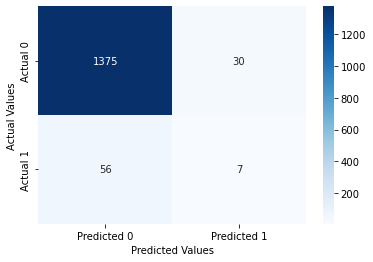

In [190]:
confusion_matrix_data(test.dropna(),test.dropna().stroke,logit_model3,cutoff=0.25)

Classification accuracy = 77.2%
Precision = 13.0%
TPR or Recall = 76.2%
FNR = 23.8%
FPR = 22.8%
ROC-AUC = 83.9%
F1 = 0.22273781902552203


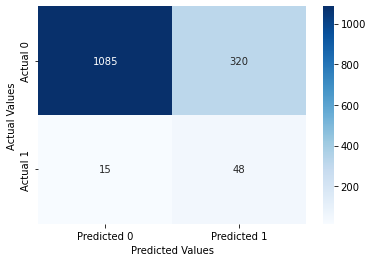

In [191]:
confusion_matrix_data(test.dropna(),test.dropna().stroke,logit_model3,cutoff=0.05)

In [47]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,imputed_bmi,bmi_original
4091,43698,Female,27.0,0,0,No,Govt_job,Rural,65.43,27.2,Unknown,0,27.2,no
3150,69979,Male,73.0,0,0,Yes,Self-employed,Rural,231.43,23.0,smokes,0,23.0,no
2668,43039,Female,63.0,0,0,Yes,Private,Rural,153.60,28.0,formerly smoked,0,28.0,no
793,69427,Female,29.0,0,0,No,Private,Urban,101.28,22.7,never smoked,0,22.7,no
798,46683,Female,25.0,0,0,No,Private,Urban,122.01,27.0,smokes,0,27.0,no


In [50]:
train.work_type.value_counts()

Private          2039
Self-employed     567
children          486
Govt_job          470
Never_worked       15
Name: work_type, dtype: int64

In [74]:
logit_model4 = sm.logit(formula = 'stroke~bmi+I(bmi*age)+avg_glucose_level+age', data = traind).fit()
logit_model4.summary()

Optimization terminated successfully.
         Current function value: 0.139646
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 3441
Model:                          Logit   Df Residuals:                     3436
Method:                           MLE   Df Model:                            4
Date:                Sun, 05 Mar 2023   Pseudo R-squ.:                  0.2047
Time:                        13:47:11   Log-Likelihood:                -480.52
converged:                       True   LL-Null:                       -604.20
Covariance Type:            nonrobust   LLR p-value:                 2.402e-52
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -11.0251      1.364     -8.082      0.000     -13.699      -8.351
bmi                   0.0970      0.039      2.501      0.012       0.021       0.173
I(bmi * age)         -0.0014      0.001     -2.238      0.025      -0.003      -0.000
avg_glucose_level     0.0049      0.002      3.237      0.001       0.002       0.008
age                   0.1192      0.021      5.704      0.000       0.078       0.160
=====================================================================================
"""

<AxesSubplot:xlabel='stroke', ylabel='age'>

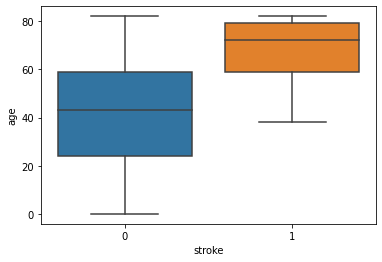

In [75]:
# More EDA for transformations
# Try visualizing stroke incidence by age
sns.boxplot(x = 'stroke', y = 'age', data = traind)

In [82]:
binned_age = pd.qcut(traind['age'], 10, retbins = True) # 9 bins, 10 limits
traind['age_binned'] = binned_age[0]

In [83]:
#Finding percentage of people having diabetes in each Age bin
age_data = traind.groupby('age_binned')['stroke'].agg([('stroke_percent','mean'),('nobs','count')]).reset_index(drop=False)
age_data

,age_binned,stroke_percent,nobs
0,"(0.079, 11.0]",0.000000,379
1,"(11.0, 21.0]",0.000000,367
2,"(21.0, 30.0]",0.000000,343
3,"(30.0, 38.0]",0.005291,378
4,"(38.0, 45.0]",0.011019,363
5,"(45.0, 52.0]",0.029891,368
6,"(52.0, 58.0]",0.062678,351
7,"(58.0, 65.0]",0.066474,346
8,"(65.0, 75.0]",0.114846,357
9,"(75.0, 82.0]",0.206154,325


Text(0.5, 0, 'Age_bin')

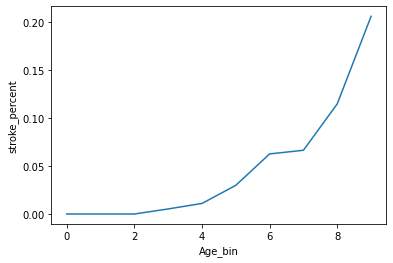

In [84]:
# Visualize percentages

sns.lineplot(x = age_data.index, y= age_data['stroke_percent'])
plt.xlabel('Age_bin')

Optimization terminated successfully.
         Current function value: 0.138902
         Iterations 11
-477.9626714868034


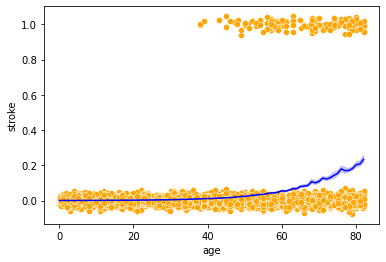

In [193]:
# Odds are not linear with age - problem, looks exponential
# maybe add a quadratic term

# Trying a quadratic transformation term
sns.scatterplot(x = jitter(traind.age,0), y = jitter(traind.stroke,0), data = traind, color = 'orange')
logit_model4 = sm.logit(formula = 'stroke~bmi+I(bmi*age)+avg_glucose_level+age+I(age**2)', data = traind).fit()
sns.lineplot(x = 'age', y= logit_model.predict(traind), data = traind, color = 'blue') 
print(logit_model4.llf) #Printing the log likelihood to compare it with the next model we build
plt.show()

In [194]:
logit_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 3441
Model:                          Logit   Df Residuals:                     3435
Method:                           MLE   Df Model:                            5
Date:                Sun, 05 Mar 2023   Pseudo R-squ.:                  0.2089
Time:                        21:32:16   Log-Likelihood:                -477.96
converged:                       True   LL-Null:                       -604.20
Covariance Type:            nonrobust   LLR p-value:                 1.611e-52
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -16.0592      3.143     -5.110      0.000     -22.218      -9.900
bmi                   0.1310      0.049      2.672      0.008       0.035       0.227
I(bmi * age)         -0.0020      0.001     -2.534      0.011      -0.004      -0.000
avg_glucose_level     0.0048      0.002      3.157      0.002       0.002       0.008
age                   0.2739      0.083      3.293      0.001       0.111       0.437
I(age ** 2)          -0.0011      0.001     -2.011      0.044      -0.002   -2.85e-05
=====================================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Classification accuracy = 62.3%
Precision = 9.2%
TPR or Recall = 87.3%
FNR = 12.7%
FPR = 38.8%
ROC-AUC = 83.6%
F1 = 0.1659125188536953


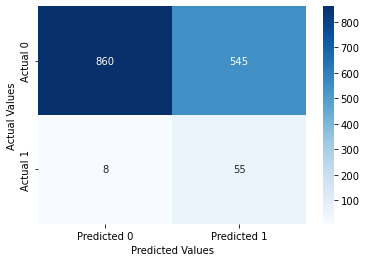

In [195]:
confusion_matrix_data(test.dropna(),test.dropna().stroke,logit_model4,cutoff=0.025)

<AxesSubplot:xlabel='stroke', ylabel='bmi'>

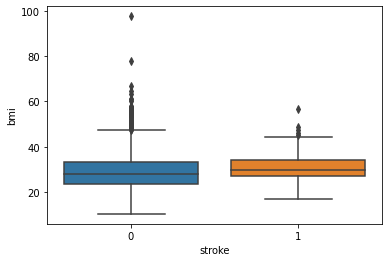

In [112]:
# visualize stroke instances by bmi
sns.boxplot(x = 'stroke', y = 'bmi', data = traind)

Besides the outliers, it doesn't look like there is much of a difference for stroke instances by bmi.

<AxesSubplot:xlabel='stroke', ylabel='avg_glucose_level'>

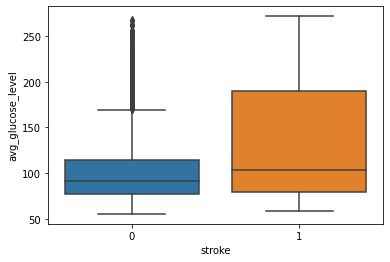

In [113]:
# visualize stroke instances by glucose level
sns.boxplot(x = 'stroke', y = 'avg_glucose_level', data = traind)

In [118]:
binned_glucose = pd.qcut(traind['avg_glucose_level'], 7, retbins = True) # 9 bins, 10 limits
traind['glucose_level_binned'] = binned_glucose[0]

In [119]:
#Finding percentage of people having diabetes in each Age bin
avg_glucose_data = traind.groupby('glucose_level_binned')['stroke'].agg([('stroke_percent','mean'),('nobs','count')]).reset_index(drop=False)
avg_glucose_data

,glucose_level_binned,stroke_percent,nobs
0,"(55.229, 69.159]",0.035225,511
1,"(69.159, 79.044]",0.052838,511
2,"(79.044, 87.106]",0.029354,511
3,"(87.106, 96.86]",0.031250,512
4,"(96.86, 110.963]",0.031373,510
5,"(110.963, 149.957]",0.037182,511
6,"(149.957, 271.74]",0.115460,511


Text(0.5, 0, 'glucose_level_bin')

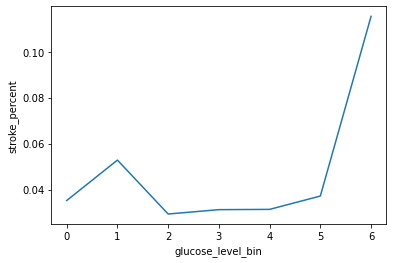

In [121]:
sns.lineplot(x = avg_glucose_data.index, y= avg_glucose_data['stroke_percent'])
plt.xlabel('glucose_level_bin')

Optimization terminated successfully.
         Current function value: 0.138897
         Iterations 11
-477.94337054024544


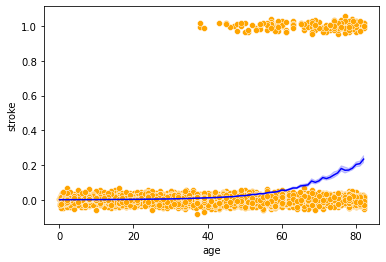

In [196]:
sns.scatterplot(x = jitter(traind.age,0), y = jitter(traind.stroke,0), data = traind, color = 'orange')
logit_model5 = sm.logit(formula = 'stroke~bmi+I(bmi*age)+avg_glucose_level+age+I(age**2)+I(avg_glucose_level**3)', data = traind).fit()
sns.lineplot(x = 'age', y= logit_model.predict(traind), data = traind, color = 'blue') 
print(logit_model5.llf) #Printing the log likelihood to compare it with the next model we build
plt.show()

In [197]:
logit_model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 3441
Model:                          Logit   Df Residuals:                     3434
Method:                           MLE   Df Model:                            6
Date:                Sun, 05 Mar 2023   Pseudo R-squ.:                  0.2090
Time:                        21:32:30   Log-Likelihood:                -477.94
converged:                       True   LL-Null:                       -604.20
Covariance Type:            nonrobust   LLR p-value:                 1.185e-51
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -16.1644      3.191     -5.066      0.000     -22.419      -9.910
bmi                           0.1313      0.049      2.672      0.008       0.035       0.228
I(bmi * age)                 -0.0020      0.001     -2.534      0.011      -0.004      -0.000
avg_glucose_level             0.0059      0.006      1.015      0.310      -0.005       0.017
age                           0.2742      0.083      3.294      0.001       0.111       0.437
I(age ** 2)                  -0.0011      0.001     -2.012      0.044      -0.002   -2.89e-05
I(avg_glucose_level ** 3) -1.504e-08   7.67e-08     -0.196      0.845   -1.65e-07    1.35e-07
=============================================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Classification accuracy = 72.9%
Precision = 11.1%
TPR or Recall = 76.2%
FNR = 23.8%
FPR = 27.3%
ROC-AUC = 83.6%
F1 = 0.19433198380566802


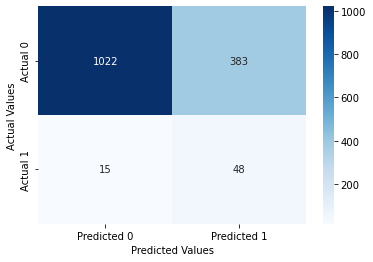

In [206]:
confusion_matrix_data(test.dropna(),test.dropna().stroke,logit_model5,cutoff=0.05)